In [10]:
from stage1 import *

In [11]:
nframes,natoms,nmols=(0,0,0)

In [12]:
from stage2 import *

In [13]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [14]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [15]:
cf=condenseframe(testframe)

In [16]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [17]:
cf

array([[-0.87917119,  1.94185346,  1.82553874,  2.28225017,  0.95225006,
         1.95350003],
       [-0.83346242,  1.9462469 ,  1.83637778,  1.36549997,  1.45650005,
         2.59900022],
       [-0.90496299,  1.93660069,  1.80534572,  0.83375001,  1.77175009,
         0.73750007],
       ...,
       [-0.94544825,  1.97721459,  1.83950346,  2.56474996,  1.57500005,
         2.47574997],
       [-0.87788869,  1.99214553,  1.87599583,  1.61825013,  1.92200017,
         2.49900007],
       [-0.80652637,  1.98965405,  1.89646377,  0.79150009,  2.24175   ,
         2.16525006]])

In [18]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:02<00:00, 24.96it/s]

30192


In [19]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [20]:
g = get_graph(cf,1,n_neigh,"cry")

In [21]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [22]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 20
batch_size=32
test_train_split = 0.8
model_name = "model2.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [23]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:00<00:00, 124448.61it/s]


In [24]:
graphs = graphs_device
total_graphs = len(graphs)


In [25]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cpu
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [26]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [27]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [28]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [29]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 39.1967
	Test: 	MSE Loss: 28.0486
Epoch: 002
	Train:	MSE Loss: 22.4976
	Test: 	MSE Loss: 26.3001
Epoch: 003
	Train:	MSE Loss: 21.1392
	Test: 	MSE Loss: 21.9840
Epoch: 004
	Train:	MSE Loss: 20.3601
	Test: 	MSE Loss: 20.7008
Epoch: 005
	Train:	MSE Loss: 20.0825
	Test: 	MSE Loss: 20.1741
Epoch: 006
	Train:	MSE Loss: 19.8499
	Test: 	MSE Loss: 19.8086
Epoch: 007
	Train:	MSE Loss: 19.6662
	Test: 	MSE Loss: 19.6827
Epoch: 008
	Train:	MSE Loss: 19.5577
	Test: 	MSE Loss: 19.5318
Epoch: 009
	Train:	MSE Loss: 19.4571
	Test: 	MSE Loss: 19.3718
Epoch: 010
	Train:	MSE Loss: 19.3680
	Test: 	MSE Loss: 20.2584
Epoch: 011
	Train:	MSE Loss: 19.2033
	Test: 	MSE Loss: 18.9607
Epoch: 012
	Train:	MSE Loss: 18.6422
	Test: 	MSE Loss: 18.2170
Epoch: 013
	Train:	MSE Loss: 17.8818
	Test: 	MSE Loss: 17.5045
Epoch: 014
	Train:	MSE Loss: 17.6056
	Test: 	MSE Loss: 17.0430
Epoch: 015
	Train:	MSE Loss: 16.8997
	Test: 	MSE Loss: 16.5260
Epoch: 016
	Train:	MSE Loss: 16.3422
	Test: 	MSE Loss: 

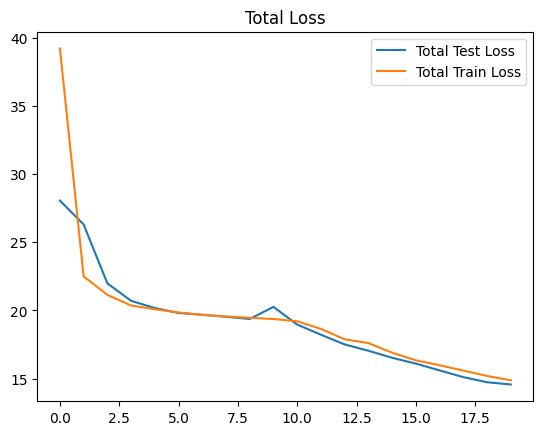

In [30]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

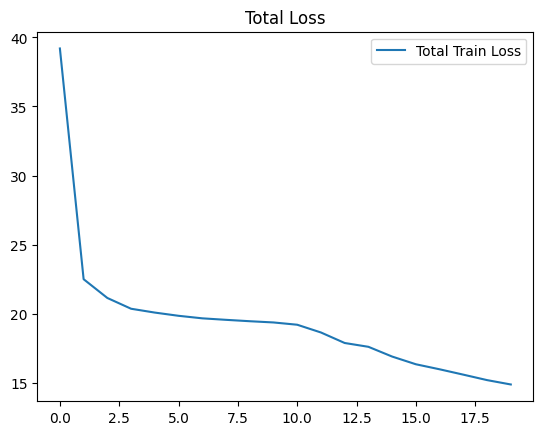

In [31]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

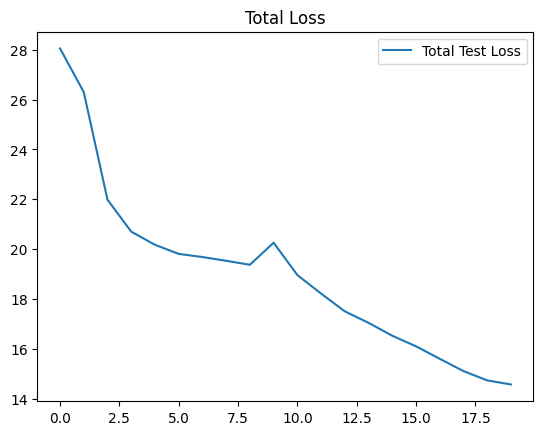

In [32]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [33]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()
    Error_total = F.mse_loss(decoded_x, test_graph.x).detach().cpu().numpy()


    avg1 += Error_wo_s
    avg2+= Error_total

print("Average Error", avg1/len(test_loader))
print("Average Error", avg2/len(test_loader))


Average Error 14.433760786667362
Average Error 14.722573363419624


In [34]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[1][heavy_indices])

21

In [35]:
input_feature[1]

tensor([[ 1.1142,  1.8929,  2.6194,  1.1575,  3.7925, 17.2350],
        [-0.3234,  1.1638,  1.3077,  1.7875,  1.2850, 15.7900],
        [ 1.2411,  1.8716,  2.6576,  3.1125,  6.0075, 16.4175],
        [-1.2398,  1.9581,  1.6935,  2.5950,  5.7725, 19.1950],
        [-1.3298,  1.9731,  1.6861,  0.1475,  4.4975, 20.1600],
        [-1.5950,  1.5496,  1.1094,  4.5500,  3.8900, 17.2150],
        [ 0.1074,  1.3874,  1.7511,  2.3525,  2.7575, 13.6750],
        [-1.7275,  1.5515,  1.0602,  4.1875,  1.1850, 16.9875],
        [ 1.0203,  1.7240,  2.4660,  0.5650,  4.8450, 13.3525],
        [-0.2927,  1.4197,  1.5398,  2.4525,  2.8475, 21.2900],
        [-1.4309,  1.1768,  0.9581,  4.9500,  3.0425, 20.1100],
        [-0.2454,  1.3767,  1.5285,  1.2550,  9.1025, 16.7275],
        [-1.3717,  1.5088,  1.1648,  0.9875,  0.8150, 12.0250],
        [-0.5479,  2.0150,  2.0025,  6.8750,  5.3800, 18.1475],
        [ 0.5286,  1.5214,  2.0230,  4.3975,  7.9950, 14.4075],
        [-0.9573,  1.7430,  1.5752,  1.6

In [36]:
input_feature[20][heavy_indices]

tensor([[-2.0790,  1.2233,  0.5523,  1.1950, 17.5275, 21.9650],
        [-1.7490,  1.5220,  0.9853,  3.5900, 17.2950, 22.9850],
        [-1.7825,  1.4553,  0.9049,  2.1700, 19.3600, 20.0700],
        [-0.4645,  1.8578,  1.8758,  1.1725, 16.2675, 19.3300],
        [-1.9297,  1.7770,  1.2946,  1.8200, 17.3025, 25.0625],
        [-1.5394,  1.4004,  0.9733,  3.1450, 20.5350, 22.4450],
        [-2.3898,  1.5786,  0.8314,  4.7075, 18.1325, 20.0700],
        [-0.4902,  1.6731,  1.7667,  0.2375, 19.2400, 18.0925],
        [-2.5750,  1.4358,  0.5863,  0.7600, 13.1300, 23.4350],
        [-0.9575,  1.1537,  0.9951,  3.2000, 13.7525, 20.0325],
        [-0.1397,  1.4994,  1.6656,  4.8250, 14.5675, 22.8625],
        [ 1.1710,  1.7929,  2.5939,  5.8500, 18.7775, 22.4225],
        [-2.4148,  1.5171,  0.7354,  1.3925, 22.0100, 24.1475],
        [-1.1835,  1.2778,  1.0676,  3.0650, 21.8075, 20.1000],
        [ 0.5665,  1.6643,  2.1897,  2.7200, 17.3675, 16.9250],
        [-0.2977,  1.4029,  1.6170,  0.9

In [37]:
decoded_feature[20][heavy_indices]

tensor([[-0.9289,  1.8315,  1.7464,  5.9341, 17.9734, 19.8832],
        [-0.8761,  1.5674,  1.5505,  7.6511, 16.3621, 18.5779],
        [-0.8901,  1.5681,  1.5462,  7.8985, 16.6447, 19.0235],
        [-0.8908,  1.5681,  1.5460,  7.9094, 16.6571, 19.0431],
        [-0.8855,  1.5679,  1.5477,  7.8162, 16.5508, 18.8753],
        [-0.8924,  1.5681,  1.5455,  7.9393, 16.6902, 19.0955],
        [-0.8862,  1.5679,  1.5474,  7.8291, 16.5655, 18.8985],
        [-0.8906,  1.5681,  1.5461,  7.9071, 16.6546, 19.0390],
        [-0.8879,  1.5680,  1.5469,  7.8585, 16.5991, 18.9515],
        [-0.8855,  1.5679,  1.5476,  7.8170, 16.5516, 18.8766],
        [-0.8934,  1.5681,  1.5451,  7.9573, 16.7089, 19.1252],
        [-0.8865,  1.5679,  1.5473,  7.8336, 16.5706, 18.9066],
        [-0.8878,  1.5680,  1.5469,  7.8569, 16.5972, 18.9485],
        [-0.8954,  1.5681,  1.5444,  7.9996, 16.7489, 19.1897],
        [-0.8933,  1.5681,  1.5452,  7.9558, 16.7073, 19.1226],
        [-0.8909,  1.5681,  1.5460,  7.9

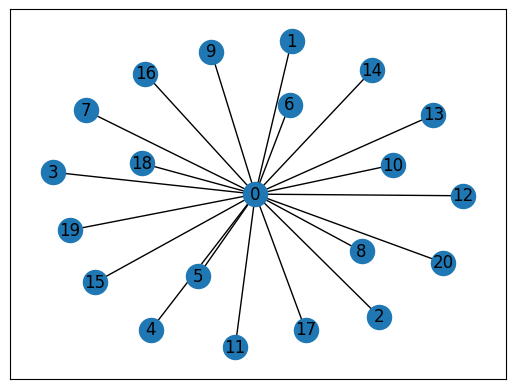

In [38]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()


In [39]:
def plotCompare(features1,features2):
    # %matplotlib widget
    xyz1 = features1[:,-3:]
    xyz2 = features2[:,-3:]
    fig = plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    ax1.scatter(xyz1[:,0],xyz1[:,1],xyz1[:,2],label="output")
    ax1.scatter(xyz2[:,0],xyz2[:,1],xyz2[:,2],label="input")
    plt.legend()
    plt.show()

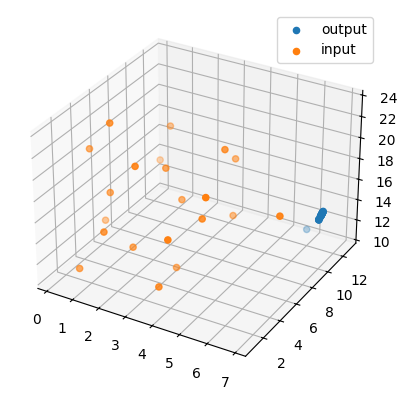

In [40]:
plotCompare(decoded_feature[1].detach().numpy(),input_feature[1].detach().numpy())


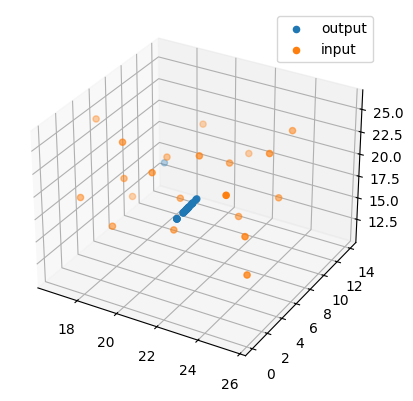

In [41]:
plotCompare(decoded_feature[15].detach().numpy(),input_feature[15].detach().numpy())

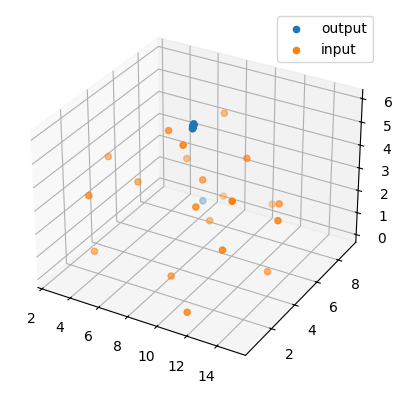

In [42]:
plotCompare(decoded_feature[39].detach().numpy(),input_feature[39].detach().numpy())